In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
import yfinance as yf
import talib
import warnings

warnings.filterwarnings('ignore')
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 5000)

In [2]:
# Control variables
use_macd = False  # Set to False to ignore MACD
harshness_factor = 4  # 1 for normal conditions, 2 for any(2), 3 for any(3)
days = 90
interval = "1H"
Ticker = '0780.hk'


# Specify start dates and end dates
end_date = date.today()
start_date = end_date - timedelta(days=days)
print('start_date:', start_date)
print('end_date:', end_date)

# Define the stock ticker
df = yf.download(Ticker, start=start_date, end=end_date, interval=interval)
# Rename columns for easier access
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

start_date: 2025-01-11
end_date: 2025-04-11
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Input today's real-time data
# real_time_price = float(input("Enter today's real-time closing price: "))
# real_time_volume = float(input("Enter today's real-time volume: "))

# # Update today's data
# df = df._append({'Close': real_time_price, 'Volume': real_time_volume * 1000000}, ignore_index=True)

In [3]:
# Calculate moving averages
df['ma20'] = df['Close'].rolling(20).mean()
df['ma50'] = df['Close'].rolling(50).mean()

# Calculate Bollinger Bands
df['upper_band'] = df['ma20'] + (df['Close'].rolling(window=20).std() * 2)
df['lower_band'] = df['ma20'] - (df['Close'].rolling(window=20).std() * 2)

# Calculate RSI and MACD
df['rsi14'] = talib.RSI(df.Close, 14)
df['macd'], df['macdsignal'], df['macdhist'] = talib.MACD(df.Close, fastperiod=14, slowperiod=53, signalperiod=5)

# Simplified Elliott Wave pattern recognition function
def identify_elliott_waves(df):
    df['elliott_wave_signal'] = ''
    for i in range(2, len(df)-2):
        if df['Close'].iloc[i] > df['Close'].iloc[i-1] and df['Close'].iloc[i] > df['Close'].iloc[i+1]:
            df['elliott_wave_signal'].iloc[i] = 'S'  # Potential peak (sell signal)
        elif df['Close'].iloc[i] < df['Close'].iloc[i-1] and df['Close'].iloc[i] < df['Close'].iloc[i+1]:
            df['elliott_wave_signal'].iloc[i] = 'B'  # Potential trough (buy signal)

# Call the function to identify Elliott Waves
identify_elliott_waves(df)

# Calculate RSV (Raw Stochastic Value)
def calculate_rsv(df, period=14):
    low_min = df['Low'].rolling(window=period).min()
    high_max = df['High'].rolling(window=period).max()
    rsv = ((df['Close'] - low_min) / (high_max - low_min)) * 100
    return rsv

df['rsv'] = calculate_rsv(df, period=14)

# Calculate KDJ
def calculate_kdj(df, period=14):
    low_min = df['Low'].rolling(window=period).min()
    high_max = df['High'].rolling(window=period).max()
    k = 100 * ((df['Close'] - low_min) / (high_max - low_min)).rolling(window=3).mean()
    d = k.rolling(window=3).mean()
    j = 3 * k - 2 * d
    return k, d, j

df['k'], df['d'], df['j'] = calculate_kdj(df)

# Initialize signals
df['signal_macd'] = ''
df['signal_rsv'] = ''
df['signal_kdj'] = ''
df['signal_bollinger'] = ''
df['final_signal'] = ''
df['macd_bullish_div'] = 0
df['macd_bearish_div'] = 0

# Generate signals based on MACD
df.loc[df['macdsignal'] <= df['macdhist'], 'signal_macd'] = 'S'  # MACD bearish
df.loc[df['macdsignal'] >= df['macdhist'], 'signal_macd'] = 'B'  # MACD bullish

# Generate signals based on RSV
df.loc[df['rsv'] >= 80, 'signal_rsv'] = 'S'  # Overbought
df.loc[df['rsv'] <= 20, 'signal_rsv'] = 'B'  # Oversold

# Generate signals based on KDJ
df.loc[df['k'] > 80, 'signal_kdj'] = 'S'  # KDJ overbought
df.loc[df['k'] < 20, 'signal_kdj'] = 'B'  # KDJ oversold

# Generate signals based on Bollinger Bands
df['signal_bollinger'] = np.where(df['Close'] > df['upper_band'], 'S',
                                   np.where(df['Close'] < df['lower_band'], 'B', ''))

# Identify MACD Divergence
for i in range(1, len(df) - 1):
    # Bullish Divergence
    if (df['Close'].iloc[i] < df['Close'].iloc[i-1] and 
        df['Close'].iloc[i] < df['Close'].iloc[i+1] and
        df['macd'].iloc[i] > df['macd'].iloc[i-1] and 
        df['macd'].iloc[i] > df['macd'].iloc[i+1]):
            df['macd_bullish_div'].iloc[i] = 1  # Mark bullish divergence

    # Bearish Divergence
    if (df['Close'].iloc[i] > df['Close'].iloc[i-1] and 
        df['Close'].iloc[i] > df['Close'].iloc[i+1] and
        df['macd'].iloc[i] < df['macd'].iloc[i-1] and 
        df['macd'].iloc[i] < df['macd'].iloc[i+1]):
            df['macd_bearish_div'].iloc[i] = 1  # Mark bearish divergence


In [4]:
# Count the signals for Buy and Sell
buy_signals = (df['signal_rsv'] == 'B').astype(int) + \
              (df['signal_macd'] == 'B').astype(int) + \
              (df['signal_kdj'] == 'B').astype(int) + \
              (df['signal_bollinger'] == 'B').astype(int) + \
              df['macd_bullish_div']

sell_signals = (df['signal_rsv'] == 'S').astype(int) + \
               (df['signal_macd'] == 'S').astype(int) + \
               (df['signal_kdj'] == 'S').astype(int) + \
               (df['signal_bollinger'] == 'S').astype(int) + \
               df['macd_bearish_div']

# Assign final signals based on combined logic
df['final_signal'] = np.where(buy_signals >= harshness_factor, 'B',
                              np.where(sell_signals >= harshness_factor, 'S', ''))

# Combine all signals into a final signal
df['final_combined_signal'] = np.where(
    df['final_signal'] == 'B', 'B',
    np.where(df['final_signal'] == 'S', 'S',
             np.where(df['elliott_wave_signal'] == 'B', 'B',
                      np.where(df['elliott_wave_signal'] == 'S', 'S', ''))))

# Calculate future prices for PnL calculations
df['Future_Close_1d'] = df['Close'].shift(-1)
df['Future_Close_3d'] = df['Close'].shift(-3)
df['Future_Close_7d'] = df['Close'].shift(-7)
df['Future_Close_30d'] = df['Close'].shift(-30)

# Calculate PnL for each signal
df['PnL_1d'] = np.where(df['final_combined_signal'] == 'B', (df['Future_Close_1d'] - df['Close']) / df['Close'], np.nan)
df['PnL_3d'] = np.where(df['final_combined_signal'] == 'B', (df['Future_Close_3d'] - df['Close']) / df['Close'], np.nan)
df['PnL_7d'] = np.where(df['final_combined_signal'] == 'B', (df['Future_Close_7d'] - df['Close']) / df['Close'], np.nan)
df['PnL_30d_%'] = np.where(df['final_combined_signal'] == 'B', (df['Future_Close_30d'] - df['Close']) / df['Close'] * 100, np.nan)

# Mark sells
df['PnL_1d'] = np.where(df['final_combined_signal'] == 'S', (df['Close'] - df['Future_Close_1d']) / df['Close'], df['PnL_1d'])
df['PnL_3d'] = np.where(df['final_combined_signal'] == 'S', (df['Close'] - df['Future_Close_3d']) / df['Close'], df['PnL_3d'])
df['PnL_7d'] = np.where(df['final_combined_signal'] == 'S', (df['Close'] - df['Future_Close_7d']) / df['Close'], df['PnL_7d'])
df['PnL_30d_%'] = np.where(df['final_combined_signal'] == 'S', (df['Close'] - df['Future_Close_30d']) / df['Close'] * 100, df['PnL_30d_%'])

# Remove future price columns after PnL calculations
df.drop(columns=['Future_Close_1d', 'Future_Close_3d', 'Future_Close_7d', 
                 'Future_Close_30d'], inplace=True)

# After signal generation
num_buy_signals = (df['final_combined_signal'] == 'B').sum()
num_sell_signals = (df['final_combined_signal'] == 'S').sum()
print(f"Total Buy Signals: {num_buy_signals}, Total Sell Signals: {num_sell_signals}")


# Calculate historical maximum drawdown
df['max_drawdown_365'] = df['Close'].rolling(window=365).apply(lambda x: (x.max() - x.min()) / x.max(), raw=True)

# Calculate predicted drawdown (using lower Bollinger Band as a proxy)
df['predicted_drawdown'] = (df['Close'] - df['lower_band']) / df['Close']

Total Buy Signals: 97, Total Sell Signals: 96


In [5]:
# Initialize stop loss signals
df['stop_loss_signal'] = ''

# Generate stop loss signals
for i in range(1, len(df)):
    # Stop loss based on historical maximum drawdown
    if df['Close'].iloc[i] < df['Close'].iloc[i-1] * (1 - df['max_drawdown_365'].iloc[i-1]):
        df['stop_loss_signal'].iloc[i] = 'SL_HIST'

    # Stop loss based on predicted drawdown
    if df['Close'].iloc[i] < df['lower_band'].iloc[i]:
        df['stop_loss_signal'].iloc[i] = 'SL_PRED'

In [6]:
# Final investment value from the strategy
initial_investment = 10000
cash = initial_investment
shares = 0
investment_value_over_time = []

# Risk management parameters
risk_per_trade = 0.5  # Risk 0.5% of cash per trade

# Simulate the strategy using final_combined_signal and stop loss
for index, row in df.iterrows():
    try:
        # Buy signal based on final_combined_signal
        if row['final_combined_signal'] == 'B' and cash > 0:  # Buy signal
            shares_to_buy = int(cash * risk_per_trade / row['Close'])  # Calculate shares based on risk
            if shares_to_buy > 0:  # Ensure we're buying at least one share
                shares += shares_to_buy
                cash -= shares_to_buy * row['Close']  # Deduct the cash spent

        # Sell signal based on final_combined_signal or stop loss
        elif (row['final_combined_signal'] == 'S' or row['stop_loss_signal'] != '') and shares > 0:  # Sell signal
            cash += shares * row['Close']  # Add the cash from selling
            shares = 0  # Reset shares

        # Calculate total value at the end of each day
        total_value = cash + shares * row['Close']
        investment_value_over_time.append(total_value)
    except Exception as e:
        print(f"Error processing row {index}: {e}")
        investment_value_over_time.append(cash + shares * row['Close'])

# Final investment value from the strategy
final_strategy_value = investment_value_over_time[-1]

# Simulate Buy and Hold Strategy
initial_price = df['Close'].iloc[0]
final_price = df['Close'].iloc[-1]
final_hold_value = initial_investment * (final_price / initial_price)

# Display final results
print(f"Final Strategy Value: ${final_strategy_value:.2f}")
print(f"Final Buy and Hold Value: ${final_hold_value:.2f}")

# Calculate statistics
def calculate_statistics(signal_type):
    trades = df[df['final_combined_signal'] == signal_type]
    total_trades = len(trades)
    if total_trades == 0:
        return {'win_rate': 0, 'avg_PnL': 0}

    wins = trades[trades['PnL_30d_%'] > 0].count()['PnL_30d_%']
    avg_PnL = trades['PnL_30d_%'].mean()

    win_rate = wins / total_trades * 100
    return {'win_rate': win_rate, 'avg_PnL': avg_PnL}

# Calculate statistics for buy and sell signals
buy_stats = calculate_statistics('B')
sell_stats = calculate_statistics('S')

print("Buy Signal Statistics:")
print(f"Win Rate: {buy_stats['win_rate']:.2f}%")
print(f"Average PnL (%): {buy_stats['avg_PnL']:.2f}%")

print("\nSell Signal Statistics:")
print(f"Win Rate: {sell_stats['win_rate']:.2f}%")
print(f"Average PnL (%): {sell_stats['avg_PnL']:.2f}%")

# Calculate Maximum Drawdown
def calculate_max_drawdown(investment_values):
    investment_series = pd.Series(investment_values)
    max_drawdown = ((investment_series.cummax() - investment_series) / investment_series.cummax()).max()
    return max_drawdown

# Calculate Sharpe Ratio
def calculate_sharpe_ratio(investment_values, risk_free_rate=0.0):
    investment_series = pd.Series(investment_values)
    daily_returns = investment_series.pct_change().dropna()
    
    if daily_returns.empty:
        return 0  # Return 0 if there are no returns
    
    excess_returns = daily_returns - risk_free_rate
    std_dev = excess_returns.std()
    
    if std_dev == 0:
        return 0  # Return 0 if standard deviation is zero
    
    sharpe_ratio = excess_returns.mean() / std_dev * np.sqrt(252)  # Annualize the Sharpe ratio
    return sharpe_ratio

# Calculate and display Maximum Drawdown and Sharpe Ratio
max_drawdown = calculate_max_drawdown(investment_value_over_time)
sharpe_ratio = calculate_sharpe_ratio(investment_value_over_time)

print(f"\nMaximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Final Strategy Value: $24769.25
Final Buy and Hold Value: $12227.32
Buy Signal Statistics:
Win Rate: 56.70%
Average PnL (%): 1.72%

Sell Signal Statistics:
Win Rate: 47.92%
Average PnL (%): -0.33%

Maximum Drawdown: 4.59%
Sharpe Ratio: 5.68


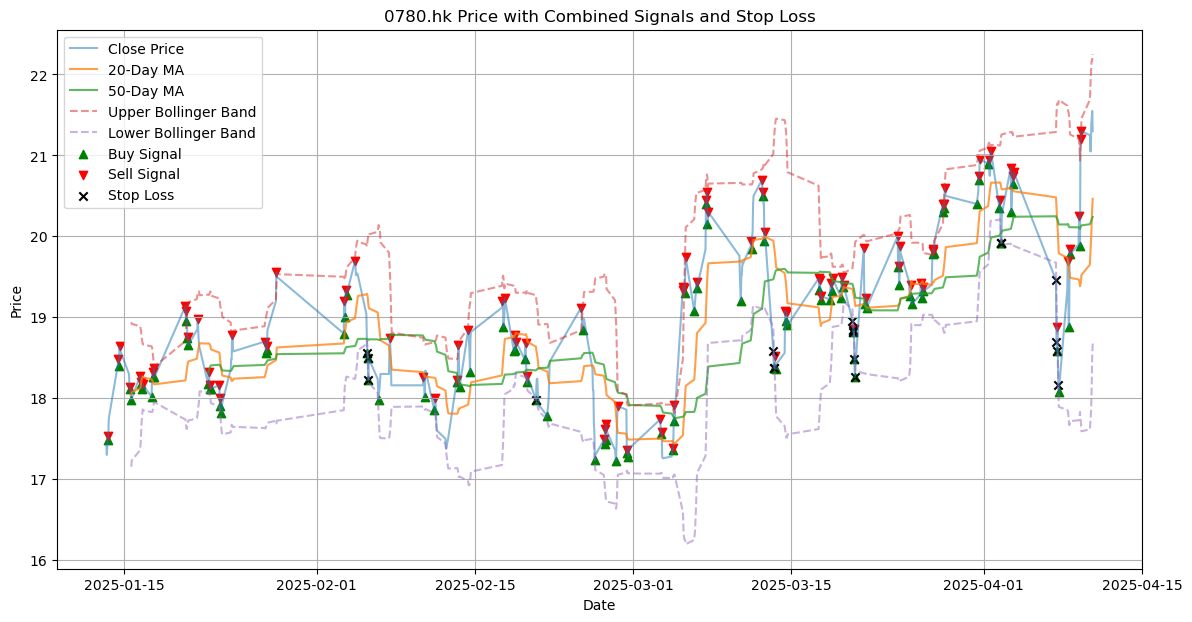

In [7]:
# Plotting the stock price and combined signals
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['ma20'], label='20-Day MA', alpha=0.75)
plt.plot(df['ma50'], label='50-Day MA', alpha=0.75)
plt.plot(df['upper_band'], label='Upper Bollinger Band', linestyle='--', alpha=0.5)
plt.plot(df['lower_band'], label='Lower Bollinger Band', linestyle='--', alpha=0.5)

# Plot buy signals
plt.scatter(df.index[df['final_combined_signal'] == 'B'], df[df['final_combined_signal'] == 'B']['Close'], 
            marker='^', color='g', label='Buy Signal', alpha=1)

# Plot sell signals
plt.scatter(df.index[df['final_combined_signal'] == 'S'], df[df['final_combined_signal'] == 'S']['Close'], 
            marker='v', color='r', label='Sell Signal', alpha=1)

# Plot stop loss signals
plt.scatter(df.index[df['stop_loss_signal'] != ''], df[df['stop_loss_signal'] != '']['Close'], 
            marker='x', color='k', label='Stop Loss', alpha=1)

plt.title(f'{Ticker} Price with Combined Signals and Stop Loss')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [8]:
df

,Close,High,Low,Open,Volume,ma20,ma50,upper_band,lower_band,rsi14,...,macd_bullish_div,macd_bearish_div,final_combined_signal,PnL_1d,PnL_3d,PnL_7d,PnL_30d_%,max_drawdown_365,predicted_drawdown,stop_loss_signal
Datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-13 09:30:00,17.420000,17.780001,17.059999,17.200001,2161600,NaN,NaN,NaN,NaN,NaN,...,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,
2025-01-13 10:30:00,17.299999,17.559999,17.280001,17.420000,1255200,NaN,NaN,NaN,NaN,NaN,...,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,
2025-01-13 11:30:00,17.400000,17.459999,17.299999,17.320000,172400,NaN,NaN,NaN,NaN,NaN,...,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,
2025-01-13 12:30:00,17.540001,17.559999,17.420000,17.420000,267085,NaN,NaN,NaN,NaN,NaN,...,0,0,S,0.003421,-0.013683,-0.054732,-4.789043,NaN,NaN,
2025-01-13 13:30:00,17.480000,17.540001,17.440001,17.540001,565600,NaN,NaN,NaN,NaN,NaN,...,0,0,B,0.013730,0.052632,0.066362,4.462247,NaN,NaN,
2025-01-13 14:30:00,17.719999,17.719999,17.480000,17.480000,1026400,NaN,NaN,NaN,NaN,NaN,...,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,
2025-01-13 15:30:00,17.780001,17.860001,17.700001,17.719999,1953200,NaN,NaN,NaN,NaN,NaN,...,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,
2025-01-14 09:30:00,18.400000,18.420000,17.780001,17.799999,2351600,NaN,NaN,NaN,NaN,NaN,...,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,
2025-01-14 10:30:00,18.480000,18.620001,18.379999,18.420000,1661818,NaN,NaN,NaN,NaN,NaN,...,0,0,S,0.004329,-0.008658,0.017316,-2.922083,NaN,NaN,


In [9]:
# Save DataFrame to Excel
df.to_excel(f'{Ticker}_with_stop_loss.xlsx')